In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datadata import utils
from prevision import *
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display


In [19]:
input_sequence_length=14
output_sequence_length=1
SCORING=0 # 0 for MSE, 1 for MAE
EVAL_METRIC=1
scoring_RCV = {0:'neg_mean_squared_error',1:'neg_mean_absolute_error'}[SCORING]
scoring_Ray={0:'rmse',1:'mae'}[SCORING]
eval_metric={0:'rmse',1:'mae'}[SCORING]
HOURLY=True
df_all,x,y=getAllDataFromCSV(hourly=HOURLY)

In [31]:
x.head()
y.head()

,h_11:30,h_12:00,h_12:30,h_13:00,h_13:30,h_14:00,h_14:30,h_15:00,h_15:30,h_16:00,...,h_19:00,h_19:30,h_20:00,h_20:30,h_21:00,h_21:30,h_22:00,h_22:30,h_23:00,h_23:30
date,,,,,,,,,,,,,,,,,,,,,
2023-02-13,60.04,206.69,321.44,754.97,262.85,65.25,219.92,346.90,316.16,169.05,...,1000.25,1026.84,707.66,398.47,809.97,115.34,61.96,-98.07,-105.82,254.00
2023-02-14,79.00,971.77,1648.67,380.79,370.26,105.62,278.29,864.60,1252.16,424.41,...,1030.06,1246.99,786.64,1392.95,721.78,123.35,97.01,35.24,-74.90,264.50
2023-02-15,202.25,1536.33,3945.28,86.87,87.39,575.90,117.17,182.31,323.04,332.62,...,1380.07,1426.87,876.58,740.11,768.95,538.73,90.58,127.90,298.29,24.87
2023-02-16,249.75,1329.48,2808.12,903.80,658.57,435.59,248.85,114.25,113.20,218.47,...,1475.65,1499.67,892.85,1060.81,1342.22,711.29,890.35,892.47,177.12,671.91
2023-02-17,197.91,165.18,673.72,654.50,247.07,138.15,171.58,402.42,534.87,578.87,...,1583.92,1279.22,1428.32,1870.14,1193.53,1167.26,1129.64,860.56,357.07,595.95


In [46]:
class WindowGenerator():
    def __init__(self, X, Y, input_sequence_length=14, output_sequence_length=7):
        self.X=X
        self.Y=Y
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        
        assert (len(self.X) - self.input_sequence_length - self.output_sequence_length + 1 > 0), \
            f'Dataset size too small for current options\ndata:{len(self.X)}, ' \
            f'input_sequence_length:{input_sequence_length}, output_sequence_length:{output_sequence_length}'

    def __len__(self):  # number of windows we can generate to work it must be at least 1
        return len(self.X) - self.input_sequence_length - self.output_sequence_length + 1

    def __getitem__(self, idx):
        addToX=self.Y[idx:idx + self.input_sequence_length] if HOURLY else self.Y[idx:idx + self.input_sequence_length] [:, None]
        x=np.concatenate(
            (self.X[idx:idx + self.input_sequence_length],addToX) ,1)
        y = self.Y[
            idx + self.input_sequence_length:idx + self.input_sequence_length + self.output_sequence_length]
        return x, y



def getXY(x,y,input_sequence_length=14, output_sequence_length=1):
    win=WindowGenerator(x,y,input_sequence_length, output_sequence_length)
    newX=[]
    newY=[]
    for i in range(len(win)):
        newX.append(win[i][0].flatten('F'))
        newY.append(win[i][1].flatten())
    return newX,newY

X,Y=x.values,y.values
n=len(x)
split=0.8
nSplit=int(n*split)
x_train_data=X[:nSplit]
y_train_data=Y[:nSplit]
x_validation_data=X[nSplit:]
y_validation_data=Y[nSplit:]

print(f"percentage split {split*100}%")
X_train,Y_train=getXY(x_train_data,y_train_data)
X_test,Y_test=getXY(x_validation_data,y_validation_data)

percentage split 80.0%


In [68]:
def featureImportance(best_model,features_names,feature_threshold=0.001):
    importance = best_model.feature_importances_
    input_size,input_sequence_length=options.input_size,options.input_sequence_length
    feature_threshold=0.001
    assert input_size*input_sequence_length==len(importance),f"Feature size calulated to be " \
    f"{input_size*input_sequence_length} but found {len(importance)}"
    reshaped_features = np.reshape(importance, (input_size,input_sequence_length))
    features_scores = np.sum(reshaped_features, axis=1)
    assert len(features_names)==len(features_scores),f"The number of feature names {len(features_names)}"\
    f" doesn't match the number of features scored {features_scores}"

    filter_indexes = [index for index, value in enumerate(features_scores) if value > feature_threshold]

    features_scores=[features_scores[i] for i in filter_indexes]
    features_names=[features_names[i] for i in filter_indexes]
    #indices = np.argsort(importances)
    n_features=len(features_scores)

    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(n_features), features_scores, align="center")
    plt.yticks(range(n_features), features_names)
    plt.ylim([-1, n_features])
    plt.tight_layout()
    plt.show()

# Training

Mean Squared Error: 233971.41875438823


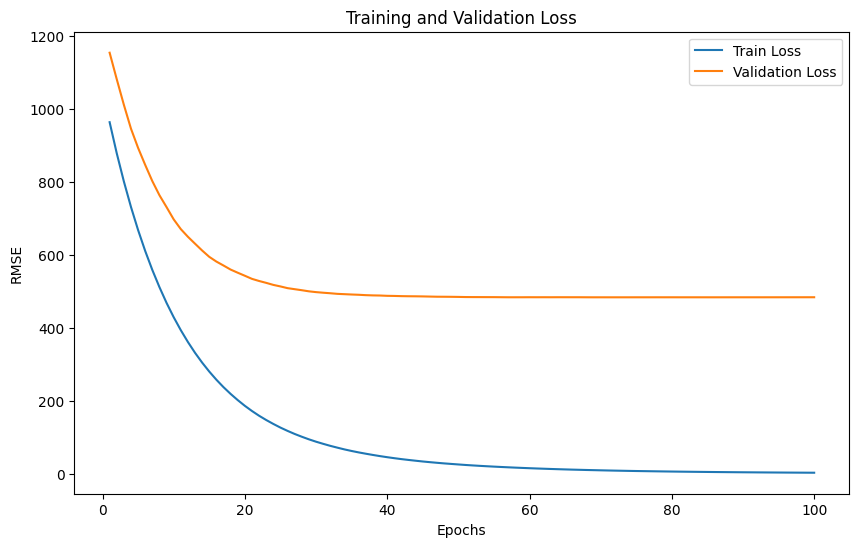

In [54]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, random_state=42)

xg_reg.fit(X_train, Y_train,
               eval_set=[(X_train, Y_train), (X_test, Y_test)],verbose=False)

# Predict the labels of the test set
y_pred = xg_reg.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(Y_test, y_pred)
print("Mean Squared Error:", mse)

plot_eval_result_XGBOOST(xg_reg.evals_result())


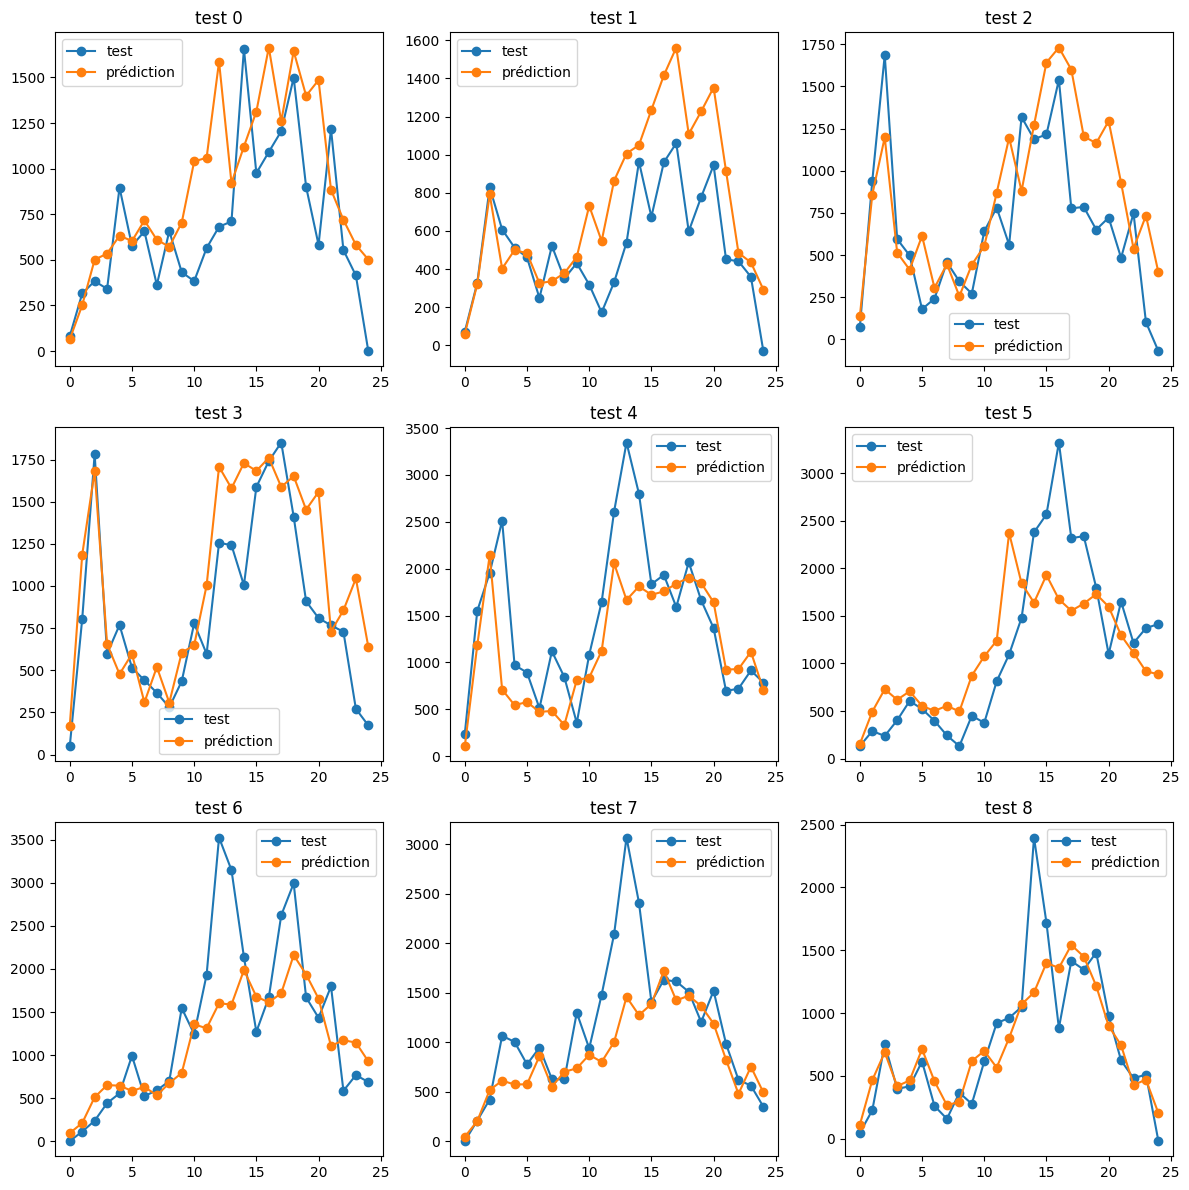

In [57]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for i in range(9):
    ax = axes[i]
    ax.plot(Y_test[i],label=f'test', linestyle="-", marker="o")
    ax.plot(y_pred[i],label=f'prédiction', linestyle="-", marker="o")
    ax.set_title(f'test {i}')
    ax.legend()
plt.tight_layout()
plt.show()



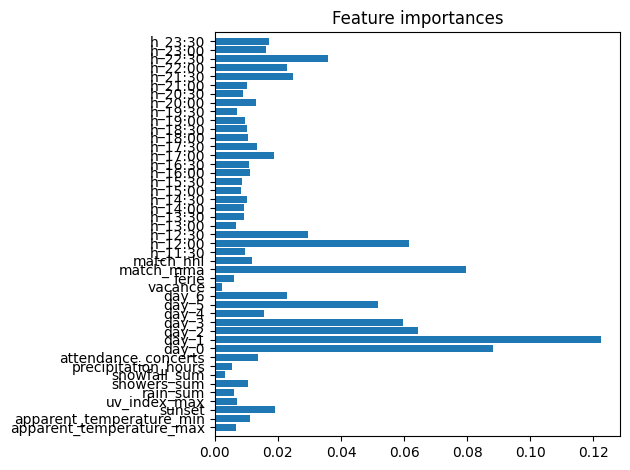

In [69]:
options = Options(model_type=XGBOOST_TYPE,input_sequence_length=14,
        output_sequence_length=1,verbose_mod = 100, input_size=52)
col_names=list(x.columns) + list(y.columns)
len(col_names)
featureImportance(xg_reg,col_names)

In [ ]:
param_space = {
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting rounds
    'max_depth': np.arange(3, 10),  # Maximum depth of the tree
    'learning_rate': np.arange(0.01, 0.1, 0.02),  # Learning rate
    'subsample': np.arange(0.7, 1.0, 0.1),  # Subsample ratio
    'colsample_bytree': np.arange(0.7, 1.0, 0.1),  # Subsample ratio of columns
}
xgb_regressor = xgb.XGBRegressor(random_state=42,eval_metric=eval_metric)
# scoring can be ‘neg_mean_absolute_error’ or 'neg_mean_squared_error'
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_space,
                                   n_iter=100, scoring=scoring_RCV, cv=3,
                                   random_state=42, verbose=1, n_jobs=-1)
random_search.fit(X_train, Y_train)

## getting best model stats

In [ ]:
best_model = random_search.best_estimator_
val_preds = best_model.predict(X_test)
val_rmse = np.sqrt(mean_squared_error(Y_test, val_preds))
val_mae = mean_absolute_error(Y_test, val_preds)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('best params\n',random_search.best_params_)

best_model.fit(X_train, Y_train,
               eval_set=[(X_train, Y_train), (X_test, Y_test)],
               verbose=0)
eval_results = best_model.evals_result()
res = best_model.predict(X_test)
plot_eval_result_XGBOOST(eval_results)

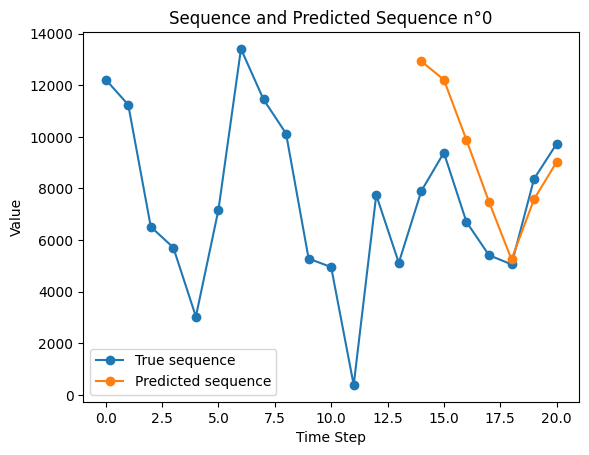

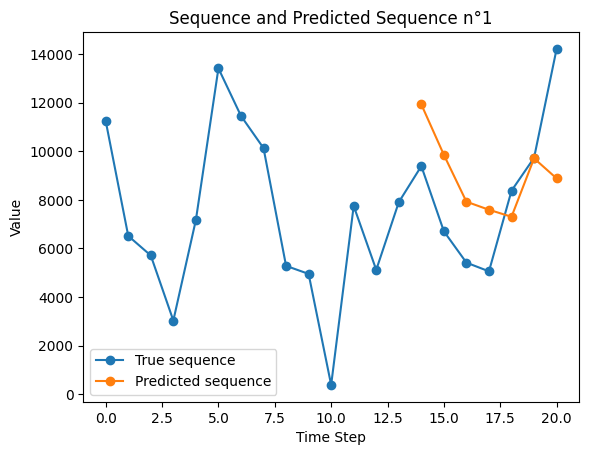

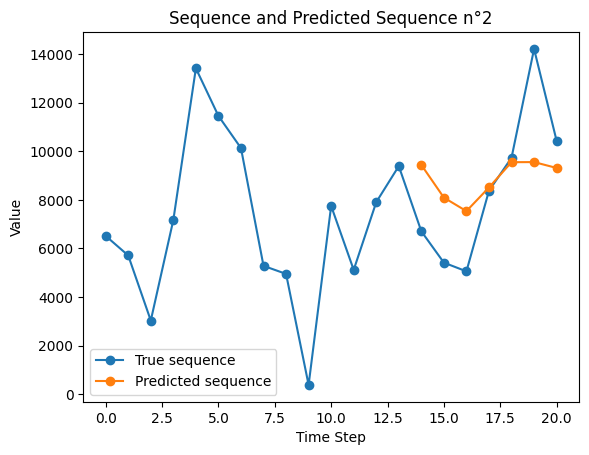

In [21]:
unflatten_X_test=np.array([x.reshape((14,28),order='F') for x in X_test])
show_test(unflatten_X_test,Y_test,res,input_sequence_length,output_sequence_length)

Best MAE validation: 2011.2135009765625
Best RMSE validation: 2559.43408203125
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.05939300189483214, 'subsample': 0.7677676796253867, 'colsample_bytree': 0.9439923071739449}


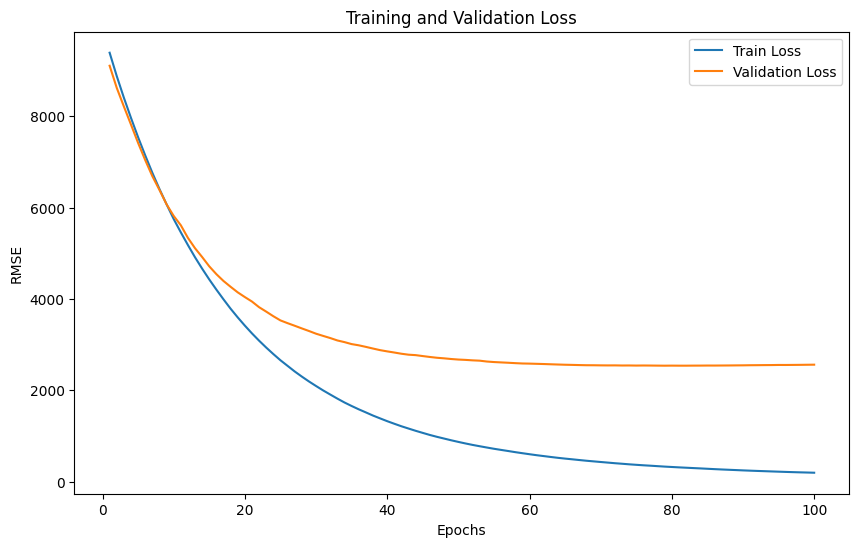

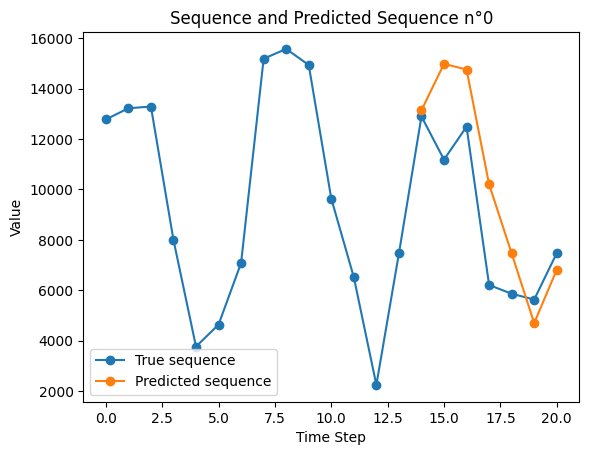

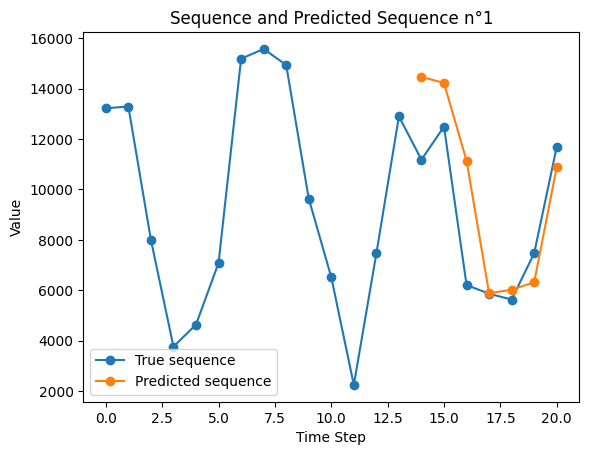

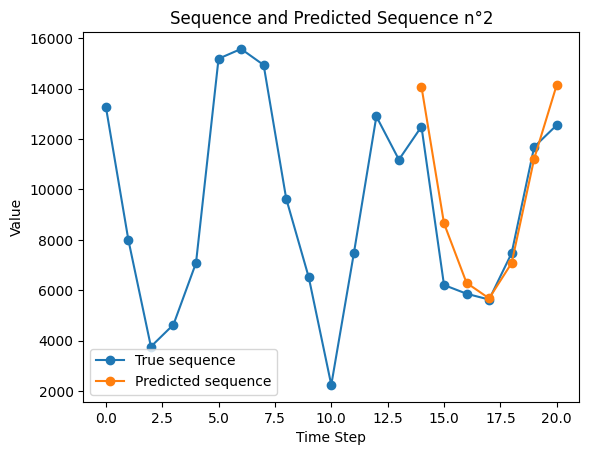

file saved at /Users/carlos/PycharmProjects/dionysos/prevision/results/Xgboost/saves/Xgboost_22.pkl


In [22]:
options = Options(model_type=XGBOOST_TYPE,input_sequence_length=input_sequence_length,
                      output_sequence_length=output_sequence_length,verbose_mod = 100, input_size=28)
a = Model(options)
b = DataLoader(options)
a.fineTuneXGBoostRay(b, None,100,scoring_Ray,eval_metric)

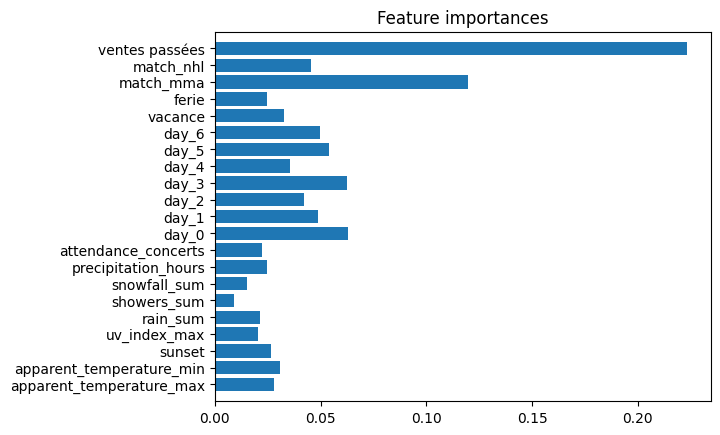

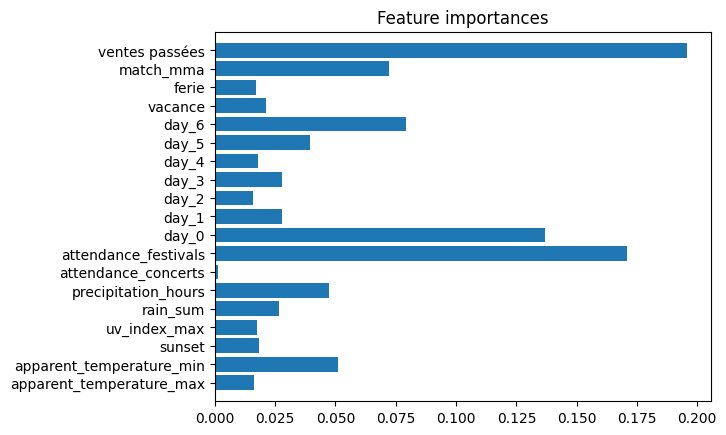

In [24]:
features_names=list(df_all.columns)+['ventes passées']
features_names.pop(0)
featureImportance(best_model,features_names)
featureImportance(a.model.model,features_names)

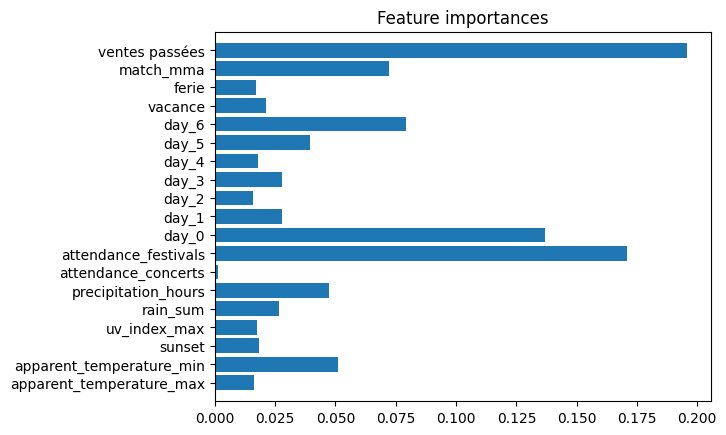

In [25]:
a.featureImportance(features_names)